# Neurally Embedded Emojis
As I move through my 20's I'm consistently delighted by the subtle ways in which I change.

- Will at 22: Reggaetón is a miserable, criminal assault to my ears.
- Will at 28: [Despacito (Remix)](https://www.youtube.com/watch?v=72UO0v5ESUo) for breakfast, lunch and dinner.


- Will at 22: Western Europe is boring. No — I've seen a lot of it! Everything is too clean, too nice, too perfect for my taste.
- Will at 28, in Barcelona, after 9 months in [Casablanca](http://willwolf.io/2016/07/29/my-open-source-machine-learning-masters-in-casablanca-morocco/): Wait a second: *I get it now*. What *is* this tropical paradise of crosswalks, vehicle civility and apple-green parks and where has it been all my life?


- Will at 22: Emojis are weird.
- Will at 28: 🚀 🤘 💃🏿 🙃.

Emojis are an increasingly-pervasive sub-lingua-franca of the internet. They capture meaning in a rich, concise manner — alternative to the 13 seconds of mobile thumb-fumbling required to capture the same meaning with text. Furthermore, they bring two levels of semantic information: their placement in raw text and the pixels of the emoji itself.

## Question-answer models
The original aim of this post was to explore Siamese question-answer models of the type typically applied to the [InsuranceQA Corpus](https://github.com/shuzi/insuranceQA) as introduced in "Applying Deep Learning To Answer Selection: A Study And An Open Task" ([Feng, Xiang, Glass, Wang, & Zhou, 2015](https://arxiv.org/pdf/1508.01585v2.pdf)). We'll call them SQAM for clarity. The basic architecture looks as follows:

![qa model architecture](./figures/qa_model_architecture.png)

By layer and in general terms:

1. An input — typically a sequence of token ids — for both question (Q) and answer (A).
2. An embedding layer.
3. Convolutional layer(s), or any layers that extract features from the matrix of embeddings. A matrix, because the respective inputs are sequences of token ids; each id is embedded into its own vector.
4. A max-pooling layer.
5. A `tanh` non-linearity.
6. The cosine of the angle between the resulting, respective embeddings.

### As canonical recommendation
Question answering can be viewed as canonical recommendation: embed entities into Euclidean space in a meaningful way, then compute dot products between these entities and sort the list. In this vein, the above network is (thus far) quite similar to classic matrix factorization.

1. Instead of factorizing our matrix via [SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition) or [OLS](https://en.wikipedia.org/wiki/Ordinary_least_squares) we build a neural network that accepts `(question, answer)`, i.e. `(user, item)`, pairs and outputs their similarity. The second-to-last layer gives the respective embeddings. We train this network in a supervised fashion, optimizing its parameters via stochastic gradient descent.
2. Instead of jumping directly from input-index (or a sequence thereof) to embedding, we first compute convolutional features.

In contrast, the network above boasts one key difference: both question and answer, i.e. user and item, are transformed via the same set of (convolutional) parameters en route to embedding.

Furthermore, and not unique to SQAMs, our inputs are *any* two sequences of (tokenized, max-padded, etc.) text: we are not restricted to only those observed in the training set.

## Question-emoji models
Given my accelerating proclivity towards the internet's new alphabet, I decided to build text-question-emoji-answer models instead. In fact, this gives yet another avenue for prediction; if we make a model of the answers (emojis) themselves, we can now predict on, i.e. compute similarity with, each of

1. Emojis we saw in the training set.
2. New emojis, i.e. either not in the training set or new (like, released months from now) altogether.
3. Novel emojis *generated* from the model of our data. In this way, we could conceivably answer a question with: "we suggest this new emoji we've algorithmically generated ourselves that no one's ever seen before."

Let's get started.

## Convolutional variational autoencoders
Variational autoencoders are comprised of two models: an encoder and a decoder. The encoder embeds our 872 emojis of size $(36, 36, 4)$ into a low-dimensional latent code, $z_e \in \mathbb{R}^{16}$, where $z_e$ is a sample from an emoji-specific Gaussian. The decoder takes as input $z_e$ and produces a reconstruction of the original emoji. As each individual $z_e$ is normally distributed, $z$ should be distributed normally as well. We can verify this with a quick simulation.

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')

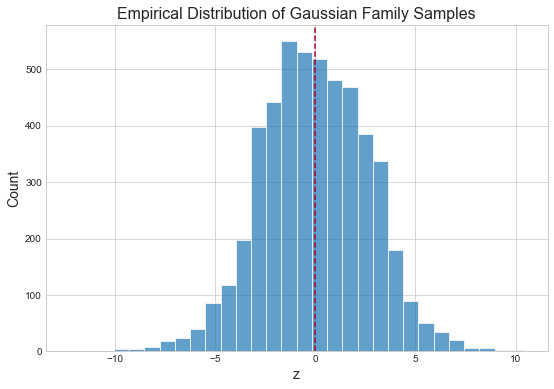

In [41]:
mu = np.linspace(-3, 3, 10)
sd = np.linspace(0, 3, 10)
z_samples = []

for m in mu:
    for s in sd:
        samples = np.random.normal(loc=m, scale=s, size=50)
        z_samples.append( samples )
        

z_samples = np.array(z_samples).ravel()

plt.figure(figsize=(9, 6))
plt.hist(z_samples, edgecolor='white', linewidth=1, bins=30, alpha=.7)
plt.axvline(0, color='#A60628', linestyle='--')
plt.xlabel('z', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Empirical Distribution of Gaussian Family Samples', fontsize=16)

Training a variational autoencoder to learn low-dimensional emoji embeddings serves several ends:

1. We can feed these low-dimensional embeddings as input to our SQAM.
2. We can generate novel emojis with which to answer questions.

As we are working with images, I employ convolutional intermediary layers.

## Data preparation

In [48]:
import os
import random

from itertools import product

import keras.backend as K
from keras.callbacks import ModelCheckpoint
from keras.layers import concatenate, dot, merge
from keras.layers import Dense, Dropout, Embedding, Flatten, Input, Lambda
from keras.layers import Bidirectional, Conv2D, Conv2DTranspose, LSTM, MaxPool1D
from keras.layers import Layer as KerasLayer, Reshape
from keras.losses import mean_squared_error, binary_crossentropy, mean_absolute_error
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.regularizers import l2
from keras.utils.vis_utils import model_to_dot

from IPython.display import SVG
from matplotlib import gridspec
import numpy as np
import pandas as pd
import PIL
from scipy.ndimage import imread
from sklearn.preprocessing import scale
import tensorflow as tf

In [43]:
EMOJIS_DIR = 'data/emojis'
N_CHANNELS = 4
EMOJI_SHAPE = (36, 36, N_CHANNELS)


emojis_dict = {}

for slug in os.listdir(EMOJIS_DIR):
    path = os.path.join(EMOJIS_DIR, slug)
    emoji = imread(path)
    if emoji.shape == (36, 36, 2):
        emoji = np.c_[emoji, np.zeros_like(emoji)]
    emojis_dict[slug] = emoji

emojis = np.array( list(emojis_dict.values()) )

### Split data into train, validation sets 

Additionally, scale pixel values to $[0, 1]$.

In [44]:
train_mask = np.random.rand( len(emojis) ) < 0.8

X_train = y_train = emojis[train_mask] / 255.
X_val = y_val = emojis[~train_mask] / 255.

print('Dataset sizes:')
print(f'    X_train:  {X_train.shape}')
print(f'    X_val:    {X_val.shape}')
print(f'    y_train:  {y_train.shape}')
print(f'    y_val:    {y_val.shape}')

Dataset sizes:
    X_train:  (703, 36, 36, 4)
    X_val:    (169, 36, 36, 4)
    y_train:  (703, 36, 36, 4)
    y_val:    (169, 36, 36, 4)


Before we begin, let's examine some emojis.

In [79]:
def display_emoji(emoji_arr):
    return PIL.Image.fromarray(emoji_arr)


# def display_prediction(pred):
#     pred = (pred * 255).astype(np.uint8)
#     return display_emoji(pred)

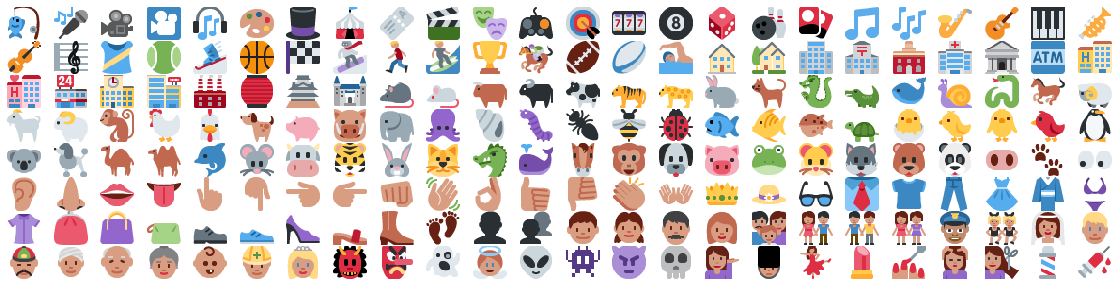

In [81]:
n_rows = 8
n_cols = 24

plt.figure(figsize=(20, 5))
gs = gridspec.GridSpec(n_rows, n_cols, wspace=.025, hspace=.025)

for i, (r, c) in enumerate(product(range(n_rows), range(n_cols))):
    ax = plt.subplot(gs[i])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')
    ax.imshow(emojis[i + 200], cmap='gray', interpolation='nearest')

plt.savefig('figures/emojis.png', bbox_inches='tight')

## Model emojis

In [84]:
EMBEDDING_SIZE = 16
FILTER_SIZE = 64
BATCH_SIZE = 16
WEIGHTS_PATH = 'weights/epoch_{epoch:02d}-loss_{val_loss:.2f}.hdf5'

### Variational layer

This is taken from a previous post of mine, [Transfer Learning for Flight Delay Prediction via Variational Autoencoders](http://willwolf.io/2017/05/08/transfer-learning-flight-delay-prediction/).

In [85]:
class VariationalLayer(KerasLayer):

    def __init__(self, embedding_dim: int, epsilon_std=1.):
        '''A custom "variational" Keras layer that completes the
        variational autoencoder.

        Args:
            embedding_dim : The desired number of latent dimensions in our
                embedding space.
        '''
        self.embedding_dim = embedding_dim
        self.epsilon_std = epsilon_std
        super().__init__()

    def build(self, input_shape):
        self.z_mean_weights = self.add_weight(
            shape=input_shape[-1:] + (self.embedding_dim,),
            initializer='glorot_normal',
            trainable=True,
            name='z_mean_weights'
        )
        self.z_mean_bias = self.add_weight(
            shape=(self.embedding_dim,),
            initializer='zero',
            trainable=True,
            name='z_mean_bias'
        )
        self.z_log_var_weights = self.add_weight(
            shape=input_shape[-1:] + (self.embedding_dim,),
            initializer='glorot_normal',
            trainable=True,
            name='z_log_var_weights'
        )
        self.z_log_var_bias = self.add_weight(
            shape=(self.embedding_dim,),
            initializer='zero',
            trainable=True,
            name='z_log_var_bias'
        )
        super().build(input_shape)

    def call(self, x):
        z_mean = K.dot(x, self.z_mean_weights) + self.z_mean_bias
        z_log_var = K.dot(x, self.z_log_var_weights) + self.z_log_var_bias
        epsilon = K.random_normal(
            shape=K.shape(z_log_var),
            mean=0.,
            stddev=self.epsilon_std
        )

        kl_loss_numerator = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
        self.kl_loss = -0.5 * K.sum(kl_loss_numerator, axis=-1)
        return z_mean + K.exp(z_log_var / 2) * epsilon

    def loss(self, x, x_decoded):
        base_loss = binary_crossentropy(x, x_decoded)
        base_loss = tf.reduce_sum(base_loss, axis=[-1, -2])
        return base_loss + self.kl_loss

    def compute_output_shape(self, input_shape):
        return input_shape[:1] + (self.embedding_dim,)

### Autoencoder

In [86]:
# encoder
original = Input(shape=EMOJI_SHAPE, name='original')

conv = Conv2D(filters=FILTER_SIZE, kernel_size=3, input_shape=original.shape, padding='same', activation='relu')(original)
conv = Conv2D(filters=FILTER_SIZE, kernel_size=3, padding='same', activation='relu')(conv)
conv = Conv2D(filters=FILTER_SIZE, kernel_size=3, padding='same', activation='relu')(conv)

flat = Flatten()(conv)
variational_layer = VariationalLayer(EMBEDDING_SIZE)
variational_params = variational_layer(flat)

encoder = Model([original], [variational_params], name='encoder')

# decoder
encoded = Input(shape=(EMBEDDING_SIZE,))

upsample = Dense(np.multiply.reduce(EMOJI_SHAPE), activation='relu')(encoded)
reshape = Reshape(EMOJI_SHAPE)(upsample)

deconv = Conv2DTranspose(filters=FILTER_SIZE, kernel_size=3, padding='same', activation='relu', input_shape=encoded.shape)(reshape)
deconv = Conv2DTranspose(filters=FILTER_SIZE, kernel_size=3, padding='same', activation='relu')(deconv)
deconv = Conv2DTranspose(filters=FILTER_SIZE, kernel_size=3, padding='same', activation='relu')(deconv)
dropout = Dropout(.8)(deconv)
reconstructed = Conv2DTranspose(filters=N_CHANNELS, kernel_size=3, padding='same', activation='sigmoid')(dropout)

decoder = Model([encoded], [reconstructed], name='decoder')

# end-to-end
encoder_decoder = Model([original], decoder(encoder([original])))

The full model `encoder_decoder` is composed of separate models `encoder` and `decoder`. Training the former will implicitly train the latter two; they are available for our use thereafter.

The above architecture takes inspiration from [Keras](https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder_deconv.py), [Edward](https://github.com/blei-lab/edward/blob/master/examples/vae_convolutional.py) and the GDGS (gradient descent by grad student) method by as discussed by [Brudaks on Reddit](https://www.reddit.com/r/MachineLearning/comments/6hso7g/d_how_do_people_come_up_with_all_these_crazy_deep/):

> A popular method for designing deep learning architectures is GDGS (gradient descent by grad student).
This is an iterative approach, where you start with a straightforward baseline architecture (or possibly an earlier SOTA), measure its effectiveness; apply various modifications (e.g. add a highway connection here or there), see what works and what does not (i.e. where the gradient is pointing) and iterate further on from there in that direction until you reach a (local?) optimum.

I'm not a grad student, but I think it still plays.

### Fit model

In [ ]:
encoder_decoder.compile(optimizer=Adam(.003), loss=variational_layer.loss)
encoder_decoder.load_weights('weights/overfitted_weights.h5')

checkpoint_callback = ModelCheckpoint(WEIGHTS_PATH, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='auto', period=1)

encoder_decoder_fit = encoder_decoder.fit(
    x=X_train,
    y=y_train,
    batch_size=16,
    epochs=500,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint_callback]
)

# visualize features

In [ ]:
# code_16d = Input(shape=(16,), name='original')
# code_2d = Dense(2)(code_16d)
# code_16d_ = Dense(16)(code_2d)

# mini_autoencoder = Model([code_16d], [code_16d_])

In [ ]:
# mini_autoencoder.compile(optimizer=Adam(.01), loss=mean_squared_error)

In [ ]:
# mini_autoencoder.fit(x=preds, y=preds, batch_size=BATCH_SIZE, epochs=10)

In [ ]:
def compose_code(first_half, second_half):
    # change this up! go every other! have fun!
    return 8 * [first_half] + 8 * [second_half]


ticks = 20
axis = np.linspace(-2, 2, ticks)


linspace_codes = [compose_code(i, j) for i, j in product(axis, axis)]
generated_emojis = decoder.predict(linspace_codes)

In [ ]:
n_rows = n_cols = ticks

plt.figure(figsize=(12, 9))
gs = gridspec.GridSpec(n_rows, n_cols, wspace=.01, hspace=0)

for i, (r, c) in enumerate(product(range(n_rows), range(n_cols))):
    ax = plt.subplot(gs[i])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')
    ax.imshow(generated_emojis[i])

plt.suptitle('Generated Emojis')
# plt.savefig('figures/features.png', bbox_inches='tight')

In [42]:
# put here: please note: vae architecture was chosen via the hardmaru method.

# question-answer models for emoji responses
- when predicting, you can predict onto the generated emojis as well!
- add some dropout
- vanishing/exploding gradients
- spaCy for word2vec embeddings?

## bi-directional lstms
- "Bidirectional Long Short-Term Memory (biLSTM): Single direction LSTMs suffer a weakness
of not utilizing the contextual information from the future tokens. Bidirectional LSTM utilizes both
the previous and future context by processing the sequence on two directions, and generate two
independent sequences of LSTM output vectors. One processes the input sequence in the forward
direction, while the other processes the input in the reverse direction. The output at each time step
is the concatenation of the two output vectors from both directions, ie. ht =
−→ht k
←−ht ." (https://arxiv.org/pdf/1511.04108.pdf)
- when discussing this thing, talk a bit about the jeremy howard course, returning the sequences, etc.

# text
- tokens to word2vec vectors, maybe via spacy
- embed into sentence matrix via bi-directional lstm
- attention mechanism, i think (or maybe omit)
- max-pool
- dense-layer (same as above)
- tanh
- cosine

# emoji
- dense layer
- concat with attention mechanism vector (or maybe omit)
- max-pool
- dense-layer (same as above)
- tanh
- cosine

In [ ]:
# import airlines tweets

In [ ]:
import pandas as pd

In [ ]:
tweets_df = pd.read_csv('data/tweets.csv')[['text', 'airline_sentiment']]\
    .sample(5000)\
    .reset_index()
tweets_df.head()

In [ ]:
encoder_decoder.load_weights('weights/epoch_01-loss_544.55.hdf5')

In [ ]:
labels_array = np.array([emojis_dict['1f389.png'], emojis_dict['1f608.png'], emojis_dict['1f621.png']])
encodings = encoder.predict(labels_array).astype(np.float64)

encodings = scale(encodings)

In [ ]:
positive_emb, neutral_emb, negative_emb = encodings
embedding_map = {'positive': positive_emb, 'neutral': neutral_emb, 'negative': negative_emb}

In [ ]:
incorrect_answers, correct_answers = [], []
sentiments = {'positive', 'neutral', 'negative'}
for sentiment in tweets_df['airline_sentiment']:
    correct_answers.append( embedding_map[sentiment] )
    incorrect_sentiment = random.sample(sentiments - {sentiment}, 1)[0]
    incorrect_answers.append( embedding_map[incorrect_sentiment] )
    

questions = tweets_df['text']
correct_answers = np.array(correct_answers)
incorrect_answers = np.array(incorrect_answers)

In [ ]:
MAX_QUESTION_LEN = 20
VOCAB_SIZE = 2000

In [ ]:
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(questions)
question_seqs = tokenizer.texts_to_sequences(questions)
question_seqs = pad_sequences(question_seqs, maxlen=MAX_QUESTION_LEN)

In [ ]:
# split into train, validation
word_index = tokenizer.word_index

train_mask = np.random.rand( len(question_seqs) ) < 0.8

questions_train = question_seqs[train_mask]
correct_answers_train = correct_answers[train_mask]
incorrect_answers_train = incorrect_answers[train_mask]

questions_val = question_seqs[~train_mask]
correct_answers_val = correct_answers[~train_mask]
incorrect_answers_val = incorrect_answers[~train_mask]

y_train_dummy = np.zeros(shape=questions_train.shape[0])
y_val_dummy = np.zeros(shape=questions_val.shape[0])

In [ ]:
GLOVE_EMBEDDINGS_DIR = 'data/glove.6B'
EMBEDDING_DIM = 100

In [ ]:
# hydrate embedding layer
# THIS CODE WAS TAKEN FROM https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html
# francois: i'll try to make a pull request if i have time

embeddings_index = {}
f = open(os.path.join(GLOVE_EMBEDDINGS_DIR, f'glove.6B.{EMBEDDING_DIM}d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_layer = Embedding(
    input_dim=len(word_index) + 1,
    output_dim=EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_QUESTION_LEN,
    trainable=True
)

In [ ]:
# question/answer model

# question
question = Input(shape=(MAX_QUESTION_LEN,), dtype='int32')

question_embedding = embedding_layer(question)
biLSTM = Bidirectional(LSTM(50, return_sequences=True))(question_embedding)
max_pool = MaxPool1D(10)(biLSTM)
flat = Flatten()(max_pool)
dense_question = Dense(10)(flat)

# answer
answer = Input(shape=(EMBEDDING_SIZE,))
dense_answer = Dense(64, activation='relu')(answer)
dense_answer = Dense(10, activation='relu')(answer)

# combine
shared_dense_1 = Dense(100, activation='relu')
shared_dense_2 = Dense(50, activation='relu')
shared_dense_3 = Dense(10, activation='tanh')

dense_answer = shared_dense_1(dense_answer)
dense_question = shared_dense_1(dense_question)

dense_answer = shared_dense_2(dense_answer)
dense_question = shared_dense_2(dense_question)

dense_answer = shared_dense_3(dense_answer)
dense_question = shared_dense_3(dense_question)

# compute cosine sim - normalized dot product
cosine_sim = dot([dense_question, dense_answer], axes=-1)

# model
qa_model = Model([question, answer], [cosine_sim], name='qa_model')

In [ ]:
# contrastive model
correct_answer = Input(shape=(EMBEDDING_SIZE,))
incorrect_answer = Input(shape=(EMBEDDING_SIZE,))
correct_cos_sim = qa_model([question, correct_answer])
incorrect_cos_sim = qa_model([question, incorrect_answer])

def max_margin_loss(cos_sims, margin=.2):
    correct, incorrect = cos_sims
    # differentiable
    return K.relu(margin - correct + incorrect)

contrastive_loss = Lambda(max_margin_loss)([correct_cos_sim, incorrect_cos_sim])

# model
contrastive_model = Model([question, correct_answer, incorrect_answer], [contrastive_loss], name='contrastive_model')

# prediction_model
prediction_model = Model([question, answer], qa_model([question, answer]), name='prediction_model')

In [ ]:
# compile
optimizer = SGD(.001, clipnorm=1.)

contrastive_model.compile(loss=lambda y_true, y_pred: y_pred, optimizer=optimizer)
prediction_model.compile(loss=lambda y_true, y_pred: y_pred, optimizer=optimizer)

In [ ]:
# SVG(model_to_dot(qa_model).create(prog='dot', format='svg'))

In [ ]:
contrastive_model.fit(
    x=[questions_train, correct_answers_train, incorrect_answers_train],
    y=y_train_dummy,
    batch_size=64,
    epochs=5,
    validation_data=([questions_val, correct_answers_val, incorrect_answers_val], y_val_dummy)
)

In [ ]:
questions[4]

In [ ]:
q = questions[1402]

In [ ]:
q_seq = question_seqs[4]

q_input = np.tile(q_seq, (3, 1))

In [ ]:
pred_cos_sim = prediction_model.predict([q_input, encodings])

In [ ]:
pred_cos_sim

In [ ]:
full_encodings = encoder.predict(emojis).astype(np.float64)
inf_mask = np.isinf(full_encodings).any(axis=1)
full_encodings = full_encodings[~inf_mask]

In [ ]:
q_input = np.tile(q_seq, (len(full_encodings), 1))

In [ ]:
pred_cos_sim = prediction_model.predict([q_input, full_encodings]).ravel()

In [ ]:
temp = np.argpartition(-pred_cos_sim, 4)
result_args = pred_cos_sim[:4]

In [ ]:
pred_cos_sim.max()

In [ ]:
pred_cos_sim.argsort()[-5:]

In [ ]:
pred_cos_sim[263]

In [ ]:
display_emoji(emojis[~inf_mask][263])

# this is the tweet you are using:
- "@united Flight is awful only one lavatory functioning, and people lining up, bumping, etc. because can't use 1st class bathroom. Ridiculous"

by training the training model, you're training everything up until, separately:
- cosine sim between question and good answer
- cosine sim between question and bad answer

for the training model, you take it one step further by computing the hinge loss.

- to predict, you need to create a model which takes a question and (candidate) answer, then computes the first bullet point above
- again, by training the training model, you'll have trained all of the weights for this second model
- to use it to predict, you'll just need to compile it first

lavish praise on ben.

# more things to try:
- 1d convolutions on the text!
- attention, definitely
- we can predict on our 3 labels, and also on all emojis, and also on other emojis from the continuous space!
- we need to play with the numerical stability of the encodings

# references
- http://ben.bolte.cc/blog/2016/language.html
- https://arxiv.org/pdf/1508.01585v2.pdf
- https://arxiv.org/pdf/1511.04108.pdf
- https://explosion.ai/blog/deep-learning-formula-nlp
- https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder_deconv.py